<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [3]:
# # # Google Colab
# !pip install keras_cv

In [4]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [6]:
# # Google Colab

# # Define the path to the zip file and the extraction folder
# zip_path = Path("../data/rare_species.zip")

# # Get the directory where the zip file is located
# extract_path = Path("../data/rare_species")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [7]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [8]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Feature Engineering 

<div>

In [9]:
#Load the DataFrames from the .pkl files
with open("../data/train_df.pkl", "rb") as f:
     train_df = pickle.load(f)

with open("../data/valid_df.pkl", "rb") as f:
     valid_df = pickle.load(f)

with open("../data/test_df.pkl", "rb") as f:
     test_df = pickle.load(f)

In [10]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [11]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

2025-04-19 16:01:39.616000: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-19 16:01:39.616148: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-19 16:01:39.616152: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-19 16:01:39.616830: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-19 16:01:39.616845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<div class="alert alert-block alert-success">

# **3.** Models

<div>

## ResNet50 - Margarida

In [29]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [30]:
# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment='mixup',
    oversampling=True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [31]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run2.csv",
  lr_scheduler=my_scheduler_fn
)

In [32]:
input_img = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(202, activation='softmax')(x)

# Define final model
model = models.Model(inputs=input_img, outputs=output)

In [33]:
base_model.trainable = False
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=metrics)
history = model.fit(train_ds, epochs=100, batch_size=16, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
193/350 ━━━━━━━━━━━━━━━━━━━━ 1:06 427ms/step - acc: 0.0155 - auc: 0.5240 - f1_score: 0.0090 - loss: 6.6685

KeyboardInterrupt: 

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plot_model_acc(num_epochs=5, train_loss=loss_train, train_val=loss_val)

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
xaxis = range(1,epochs+1)
plt.plot(xaxis, loss_train, 'g', label='Training loss')
plt.plot(xaxis, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

## ResNet50 - Margarida - com preprocessing

### Original

In [12]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [13]:
# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=minority_class,
    augment='mixup',
    oversampling=True,
    shuffle=True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [14]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)


In [15]:
input_img = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)


In [16]:
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="fr_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
     lr_callback]


In [17]:
# Run the experiment
history = experiment.run_experiment(callbacks=callbacks_additional, epochs=70)

No checkpoint found, starting from scratch.
Epoch 1/70


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
2025-04-18 11:47:10.144015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


350/350 ━━━━━━━━━━━━━━━━━━━━ 134s 371ms/step - accuracy: 0.0099 - auc: 0.5234 - f1_score: 0.0047 - loss: 6.9058 - val_accuracy: 0.1302 - val_auc: 0.7252 - val_f1_score: 0.0317 - val_loss: 4.7693 - learning_rate: 9.5499e-05
Epoch 2/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 142s 406ms/step - accuracy: 0.0438 - auc: 0.5690 - f1_score: 0.0201 - loss: 6.4894 - val_accuracy: 0.2115 - val_auc: 0.8016 - val_f1_score: 0.0688 - val_loss: 4.1452 - learning_rate: 9.1201e-05
Epoch 3/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 141s 402ms/step - accuracy: 0.0772 - auc: 0.6017 - f1_score: 0.0334 - loss: 5.7534 - val_accuracy: 0.2721 - val_auc: 0.8534 - val_f1_score: 0.1219 - val_loss: 3.7121 - learning_rate: 8.7096e-05
Epoch 4/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 143s 408ms/step - accuracy: 0.1255 - auc: 0.6334 - f1_score: 0.0682 - loss: 5.1376 - val_accuracy: 0.3166 - val_auc: 0.8829 - val_f1_score: 0.1673 - val_loss: 3.3997 - learning_rate: 8.3176e-05
Epoch 5/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 141s 402ms/step - accuracy: 0.1703 

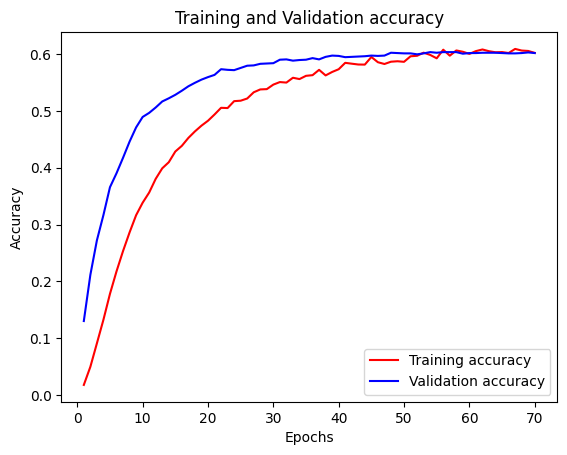

In [19]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=70, train_acc=acc_train, val_acc=acc_val)

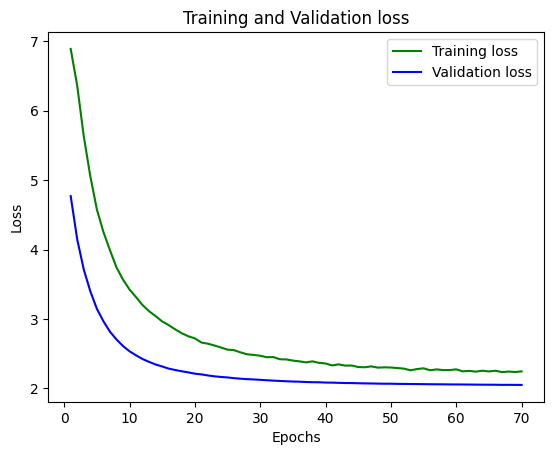

In [20]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plot_model_loss(num_epochs=70, train_loss=loss_train, val_loss=loss_val)

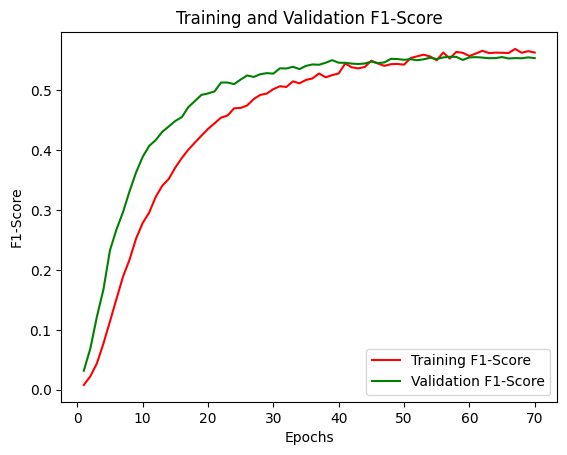

In [21]:
x_axis = range(1,70+1)
plt.plot(x_axis, history.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [22]:
experiment.model.save("fr_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_70.keras")

### Fine-tune

References: https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=pt-br

In [16]:
model_ft = load_model("project/resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_until_65.keras", compile=False)

In [ ]:
trainable = False
for layer in model_ft.layers:
    if "conv5_block1_1_conv" in layer.name:
        trainable = True
    layer.trainable = trainable

model_ft.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

In [ ]:
experiment = Experiment(
    model=model_ft,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_finetuning_phase_v2",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_finetune = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]
    
# Run the experiment
history_finetune = history = experiment.run_experiment(callbacks=callbacks_additional, epochs=15)

No checkpoint found, starting from scratch.
Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.5676 - auc: 0.7717 - f1_score: 0.4523 - loss: 2.3972

2025-04-15 21:50:12.540146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 140s 389ms/step


2025-04-15 21:52:34.239698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 279ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 352s 987ms/step - accuracy: 0.5675 - auc: 0.7717 - f1_score: 0.4523 - loss: 2.3974 - val_accuracy: 0.5582 - val_auc: 0.9557 - val_f1_score: 0.4552 - val_loss: 2.0267 - learning_rate: 9.5499e-06
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.6191 - auc: 0.7738 - f1_score: 0.5066 - loss: 2.1776

2025-04-15 21:56:38.307295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 118s 337ms/step


2025-04-15 21:58:37.486777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.6191 - auc: 0.7738 - f1_score: 0.5067 - loss: 2.1777 - val_accuracy: 0.5698 - val_auc: 0.9564 - val_f1_score: 0.4686 - val_loss: 1.9861 - learning_rate: 9.1201e-06
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.6494 - auc: 0.7774 - f1_score: 0.5321 - loss: 2.0448

2025-04-15 22:03:07.725312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 86/350 ━━━━━━━━━━━━━━━━━━━━ 1:46 403ms/step

It's already overfiting. Lets do hyperband tuner in this fine tuning phase.

### Fine tune with hyperband tuner

In [14]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [15]:
model_ft = load_model("fr_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_70.keras", compile=False)

In [16]:
len(model_ft.layers)

179

In [17]:
import keras_tuner as kt

In [18]:
def model_builder(hp):
    number_layers_unfreeze = hp.Int('number_layers_unfreeze', min_value = 1, max_value=15, step=1)

    trainable = False
    for layer in model_ft.layers:
        layer.trainable = trainable

    if number_layers_unfreeze>0:
        for layer in model_ft.layers[-number_layers_unfreeze:]:
            layer.trainable = True

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-6, 1e-7])

    model_ft.compile(optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
                    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=metrics)

    return model_ft

In [19]:
tuner = kt.Hyperband(
    hypermodel=model_builder,
    objective=kt.Objective("val_loss", direction="min"),  # ou "val_f1_score", direction="max"
    max_epochs=45,
    factor=3,
    hyperband_iterations=1,
    seed=42,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    directory='project/project',
    project_name='fr19_hyperband_finetune_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_70'
)

In [20]:
callbacks = [EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)]

In [21]:
tuner.search(
    x=train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

Trial 30 Complete [04h 51m 58s]
val_loss: 1.7993829250335693

Best val_loss So Far: 1.7790106534957886
Total elapsed time: 17h 36m 53s

Search: Running Trial #31

Value             |Best Value So Far |Hyperparameter
12                |4                 |number_layers_unfreeze
1e-06             |1e-07             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round



KeyboardInterrupt: 

**RUN 1**: The first run of the hyperband tuner showed that a small number of layers to unfreeze + small learning rates are better, so the maximum number of layers to unfreeze will be 15 and we will try a smaller value of learning rate

## EfficientNet

In [55]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

#initial_lr = 1e-4  
#final_lr = 1e-5
n_epochs = 50
#my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run2.csv",
#   lr_scheduler=my_scheduler_fn
)

In [56]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Número de classes (families) — substitui com o teu número real
num_classes = len(df['family'].unique())

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

# congela só as primeiras camadas
for layer in base_model.layers[:150]:
    layer.trainable = False

# Topo personalizado
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(202, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

# Compilar
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=metrics)

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("checkpoints/model.keras", monitor='val_loss', save_best_only=True),
    CSVLogger("logs/run2.csv")
]

In [58]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


KeyboardInterrupt: 

## VGG16

### Set-up

In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input 

In [26]:
# Load datasets
train_ds_vgg16, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment='mixup',
    shuffle=True,
    oversampling=True,
    preprocessing_function=preprocess_input)

val_ds_vgg16, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    shuffle=False,
    augment=None,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [27]:
verbose = 1

metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)

### Running the first try

In [15]:
input_img = Input(shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)

In [16]:
experiment = Experiment(
    model=model,
    train_ds= train_ds_vgg16,
    val_ds=val_ds_vgg16,
    experiment_name="vgg16_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,           # Reduce LR if no improvement after 2 epochs
        min_lr=1e-6,
        verbose=1
    )]


In [17]:
history = experiment.run_experiment(callbacks=callbacks_additional, epochs=100)

Resuming training from epoch 4
Epoch 5/100


2025-04-16 18:43:05.718190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


350/350 ━━━━━━━━━━━━━━━━━━━━ 265s 754ms/step - accuracy: 0.0156 - auc: 0.5137 - f1_score: 0.0076 - loss: 20.0013 - val_accuracy: 0.1180 - val_auc: 0.6482 - val_f1_score: 0.0271 - val_loss: 8.4591 - learning_rate: 1.0000e-04
Epoch 6/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 285s 815ms/step - accuracy: 0.0358 - auc: 0.5260 - f1_score: 0.0134 - loss: 18.5618 - val_accuracy: 0.1592 - val_auc: 0.6753 - val_f1_score: 0.0417 - val_loss: 7.9569 - learning_rate: 1.0000e-04
Epoch 7/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 289s 826ms/step - accuracy: 0.0507 - auc: 0.5355 - f1_score: 0.0199 - loss: 17.1055 - val_accuracy: 0.1848 - val_auc: 0.6966 - val_f1_score: 0.0522 - val_loss: 7.3576 - learning_rate: 1.0000e-04
Epoch 8/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 303s 866ms/step - accuracy: 0.0571 - auc: 0.5409 - f1_score: 0.0233 - loss: 15.6756 - val_accuracy: 0.2193 - val_auc: 0.7201 - val_f1_score: 0.0733 - val_loss: 6.8656 - learning_rate: 1.0000e-04
Epoch 9/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 290s 827ms/step - accuracy:

In [12]:
experiment.model.save("vgg16_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras")

NameError: name 'experiment' is not defined

In [28]:
model_vgg = load_model("vgg16_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras")

In [29]:
experiment = Experiment(
    model=model_vgg,
    train_ds= train_ds_vgg16,
    val_ds=val_ds_vgg16,
    experiment_name="vgg16_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_more_30_epochs",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,           # Reduce LR if no improvement after 2 epochs
        min_lr=1e-6,
        verbose=1
    )]

experiment.resume = False

In [30]:
history = experiment.run_experiment(callbacks=callbacks_additional, epochs=30)

Epoch 1/30


2025-04-17 11:50:01.149010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 55/350 ━━━━━━━━━━━━━━━━━━━━ 2:42 551ms/step - accuracy: 0.4748 - auc: 0.7484 - f1_score: 0.2935 - loss: 2.8846

KeyboardInterrupt: 